In [16]:
from fasttext_utils import get_submission_data, get_processed_data, select_columns, TRAIN_LENGTH
data = get_processed_data(split=False)
data = select_columns(data)
X_train, y_train, X_test, y_test = get_submission_data()

/tmp/ipykernel_12436/4270617558.py:2: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  data = get_processed_data(split=False)
/tmp/ipykernel_12436/4270617558.py:4: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  X_train, y_train, X_test, y_test = get_submission_data()


In [18]:
from catboost import CatBoostRegressor
model_cat = CatBoostRegressor(verbose=False, num_trees=2000)
model_cat.fit(X_train, y_train)
mod_preds = model_cat.predict(X_test)

In [19]:
data["hindex"][TRAIN_LENGTH:] = mod_preds
data["hindex"][data["hindex"] < 0] = 0
data["hindex"].describe()

/tmp/ipykernel_12436/3334646342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["hindex"][data["hindex"] < 0] = 0


count    217801.000000
mean         10.084120
std          12.140968
min           0.000000
25%           3.000000
50%           6.000000
75%          12.220893
max         187.000000
Name: hindex, dtype: float64

In [ ]:
from fasttext_utils import TRAIN_LENGTH
from sklearn.model_selection import train_test_split
train_np, test_np = train_test_split(data[:TRAIN_LENGTH], random_state=1)
X_train = train_np.drop(
    ["author", "hindex"], axis=1
).to_numpy()
y_train = train_np["hindex"].to_numpy()
X_test = test_np.drop(
    ["author", "hindex"], axis=1
).to_numpy()
y_test = test_np["hindex"].to_numpy()
print(X_train.shape, X_test.shape)

In [28]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
model_cat = CatBoostRegressor(verbose=False, num_trees=2000)
model_cat.fit(X_train, y_train)
mod_preds = model_cat.predict(X_test)
mean_squared_error(y_test,mod_preds)

50.21005096331262

In [27]:
int(data[data["author"] == 1964267543]["hindex"])

4

In [25]:
data.describe()

,author,hindex,nb_paper,pagerank,authority,clustering_coef,n_neighbors_dist_1,mean_neighbors_dist_1,max_neighbors_dist_1,vector_coord_0,vector_coord_1
0,1964267543,4.0,5,0.000004,3.339138e-13,1.000000,5,21.800000,39,-0.186604,0.288065
1,2153592714,13.0,5,0.000002,1.433035e-17,1.000000,2,20.000000,20,-0.239073,0.446518
2,217158525,8.0,5,0.000003,6.750288e-20,1.000000,2,2.000000,2,-0.225883,0.357737
3,2123103677,11.0,3,0.000005,7.714573e-16,0.714286,7,11.833333,54,-0.174987,0.208499
4,2067710487,3.0,2,0.000004,-1.444459e-26,0.000000,2,9.841160,12,-0.170414,0.257662


In [38]:
from read_data import get_graph
from tqdm import tqdm
import pandas as pd


def get_hindex_info(author_ids, train_data_json):
    "Return the min, the mean and the max of the known hindex of the author in author_ids"
    hindexs = [
        train_data_json[str(author_id)]
        for author_id in author_ids
        if str(author_id) in train_data_json
    ]
    if len(hindexs) > 0:
        return (
            min(hindexs),
            sum(hindexs) / len(hindexs),
            max(hindexs),
        )
    else:
        return 1, 9.841160, 12


def get_neighborhood_info(author_ids, data):
    G, _, _ = get_graph()
    info = {"author": author_ids}
    info["n_neighbors_dist_1"] = []
    # info["min_neighbors_dist_1"] = []
    info["mean_neighbors_dist_1"] = []
    info["max_neighbors_dist_1"] = []

    dict = {}
    for i in range(len(data)):
        dict[data["author"][i]] = data["hindex"][i]

    for author_id in tqdm(author_ids):
        neighbors = set()
        neighbors.update(list(G.neighbors(author_id)))
        hindexs = [
            int(dict[neighbor])
            for neighbor in neighbors
        ]
        info["n_neighbors_dist_1"].append(len(neighbors))
        # info["min_neighbors_dist_1"].append(min(hindexs))
        info["mean_neighbors_dist_1"].append(sum(hindexs) / len(hindexs))
        info["max_neighbors_dist_1"].append(max(hindexs))

    return pd.DataFrame(info)

info = get_neighborhood_info(data["author"], data)

100%|██████████| 217801/217801 [00:01<00:00, 117490.31it/s]


In [39]:
info.head()

,author,n_neighbors_dist_1,mean_neighbors_dist_1,max_neighbors_dist_1
0,1964267543,5,21.800000,39
1,2153592714,2,13.500000,20
2,217158525,2,5.000000,8
3,2123103677,7,11.571429,54
4,2067710487,2,8.000000,12


<AxesSubplot:>

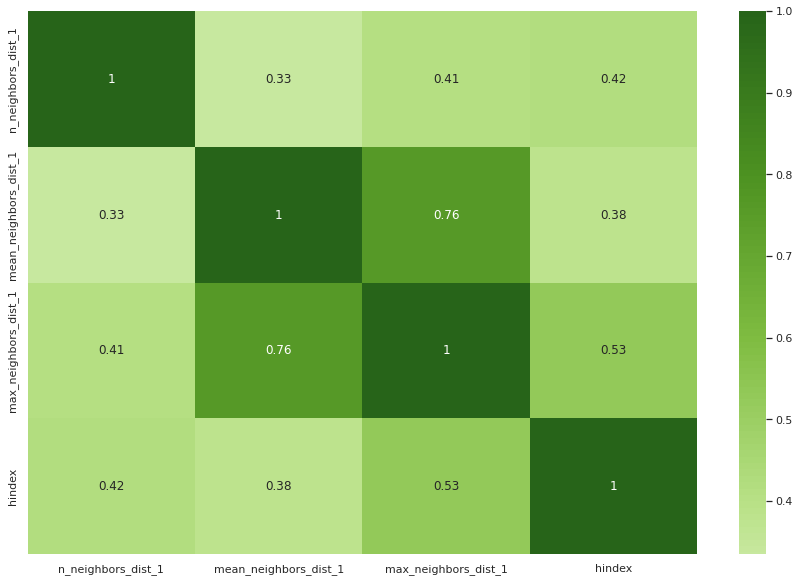

In [40]:
import seaborn as sns

info["hindex"] = data["hindex"]
corr = info.drop("author", axis=1).corr()

# plot the heatmap
sns.set(rc={"figure.figsize":(15, 10)})
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap="PiYG",
        annot = True, center=0)

<AxesSubplot:>

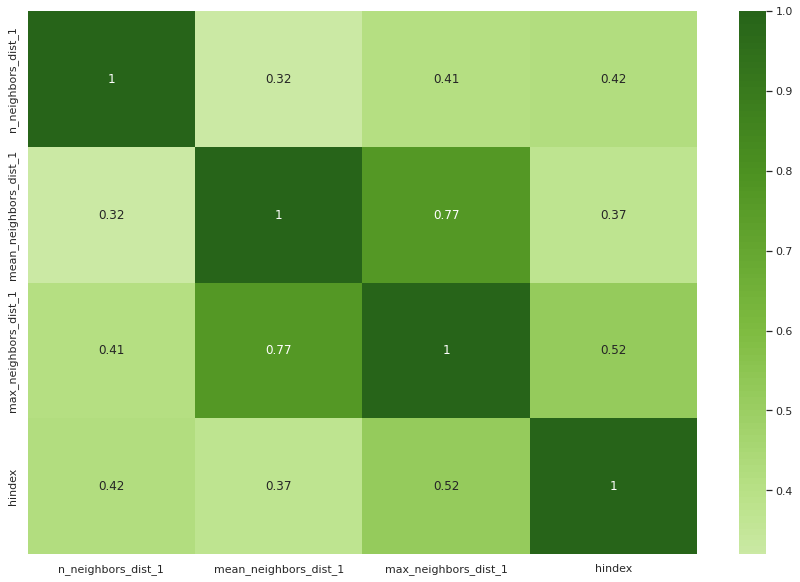

In [42]:
import seaborn as sns

corr = data[info.columns].drop("author", axis=1).corr()

# plot the heatmap
sns.set(rc={"figure.figsize":(15, 10)})
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap="PiYG",
        annot = True, center=0)

In [46]:
from fasttext_utils import TRAIN_LENGTH
from sklearn.model_selection import train_test_split
# new_data = data.copy()
# new_data[['mean_neighbors_dist_1', 'max_neighbors_dist_1']] = info[['mean_neighbors_dist_1', 'max_neighbors_dist_1']]
train_np, test_np = train_test_split(info[:TRAIN_LENGTH], random_state=1)
X_train = train_np.drop(
    ["author", "hindex"], axis=1
).to_numpy()
y_train = train_np["hindex"].to_numpy()
X_test = test_np.drop(
    ["author", "hindex"], axis=1
).to_numpy()
y_test = test_np["hindex"].to_numpy()
print(X_train.shape, X_test.shape)

(130680, 3) (43561, 3)


In [47]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
model_cat = CatBoostRegressor(verbose=False, num_trees=2000)
model_cat.fit(X_train, y_train)
mod_preds = model_cat.predict(X_test)
mean_squared_error(y_test,mod_preds)

90.80578728987862

In [48]:
from fasttext_utils import TRAIN_LENGTH
from sklearn.model_selection import train_test_split
train_np, test_np = train_test_split(data[info.columns][:TRAIN_LENGTH], random_state=1)
X_train = train_np.drop(
    ["author", "hindex"], axis=1
).to_numpy()
y_train = train_np["hindex"].to_numpy()
X_test = test_np.drop(
    ["author", "hindex"], axis=1
).to_numpy()
y_test = test_np["hindex"].to_numpy()
print(X_train.shape, X_test.shape)

(130680, 3) (43561, 3)


In [49]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
model_cat = CatBoostRegressor(verbose=False, num_trees=2000)
model_cat.fit(X_train, y_train)
mod_preds = model_cat.predict(X_test)
mean_squared_error(y_test,mod_preds)

91.80131902907692